# The Social Network

# Librairies 

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Question 1

### Résultats Théoriques 

Le but est de représenter un réseau social non-orienté par une matrice symètrique, et de simuler ces matrices sous une loi connue à une constante prêt : 
\begin{equation*}
    p(x|\theta) = \frac{1}{Z(\theta)}\exp^{\theta^{T} S(x)}
\end{equation*}
Où :
- x est la matrice en question, évoluant dans $R^{n}$, avec n le nombre d'individus
- S(x) est une statistique sur cette matrice. Nous prendrons le nombre d'arrêtes et le nombre de triangles (trois individus reliés les uns aux autres). Autrement dit : $S(x) = \big[ \sum_{i<j} x_{ij}, \sum_{i<j<k} x_{ij}x_{jk}x_{ki}\big].$ 
- $Z(\theta)$ est inconnue.
Nous pourrons ensuite trouver le paramètre sous-jacent à une observation.
Nous commençons par mettre en oeuvre un algorithme permettant de simuler x sous un $\theta$ donné.

#### Simulation par Gibbs Sampler

Afin de mettre en place cet algorithme, nous devons trouver la loi de $x{ij}$ sachant $\theta$ et tous les autres ..... de la matrice x (nous les noterons $x_{-ij}$). On a : $\forall i,j \text{ } \in \text{ } [\![1;n]\!]$

\begin{equation*}
\begin{split}
    \mathbf{P}(X_{ij} = 1 | \theta, x_{-ij}) & = \frac{\mathbf{P}(X_{ij} = 1 \cap X_{-ij} = x_{-ij} |  \theta)}{\mathbf{P}(X_{-ij} = x_{-ij}} \\
    & = \frac{\mathbf{P}(X_{ij} = 1 \cap X_{-ij} = x_{-ij} |  \theta)}{\mathbf{P}(X_{ij} = 1, X_{-ij} = x_{-ij}) + \mathbf{P}(X_{ij} = 0, X_{-ij} = x_{-ij})}\\
    & = \frac{\exp^{\theta^{T} S_{1}(x)}}{\exp^{\theta^{T} S_{1}(x)} + \exp^{\theta^{T} S_{0}(x)}} \text{ ; en simplifiant par $Z(\theta)$ en haut et en bas} \\
    & = \frac{1}{1 + \exp^{\theta^{T} (S_{0}(x) - S_{1}(x))}}
\end{split}
\end{equation*}
où $S_{1}(x)$ est la statistique de la matrice x où $x_{ij}$ vaut 1, et $S_{0}(x)$ la même chose mais pour $x_{ij}$ vallant 0.​

### Code

In [2]:
def S_consignes(M):
    g=np.triu(M)
    return np.array([np.sum(g,axis=(1,2)),np.sum(np.einsum('ijl,ilk->ijk',g,g)*g,axis=(1,2))])

In [3]:
def gibbs_etape(x, position, u, theta, S):
    ''' 
    Input :
    
    x est la matrice à l'itération k du gibbs sampler,
    position est la liste [i,j] indiquant la position de la valeur à changer 
    u une uniforme dans [0,1] tirée au préalable
    theta et S sont ceux de la densité
    
    Output :
    
    matrice à l'itération k+1 du gibbs sampler
    
    '''
    m=x.shape[0] #taille de la matrice
    
    y = x.copy() #copies modifiables
    z = x.copy()
    
    y[position[0],position[1]] = 1
    z[position[0],position[1]] = 0
    
    S_1=S(z.reshape(1,m,m))
    S_0=S(y.reshape(1,m,m))
    
    y[position[0],position[1]] = (u < 1/(1 + np.exp(theta.dot(np.subtract(S_1,S_0)))))*1
    y[position[1],position[0]] = y[position[0],position[1]]
    
    
    return(y)

In [4]:
def pos(I,N):
    """
    
    Input :
    
    I la taille totale que l'on souhaite 
    N le nombre d'individus dans le réseau
    
    Output :
    
    Toutes les positions à modifier
    
    """
    l=[]
    for i in range(N):
        for j in range(i+1,N):
            l+=[[i,j]]
    return np.array(l*(I//len(l))+l[:I%len(l)])

In [5]:
def gibbs (I, N, theta, S, X='default',last_sample=False,H=1):
    """
    Input :
    I le nombre d'itération dans le gibbs sampling
    N le nombre d'individus dans le réseau 
    theta un array pour les paramètres de la loi 
    
    S une fonction vectorisable sur une liste de matrices (statistique exhaustive de notre loi)
    last_sample=True sin on veut juste la dernière matrice
    H l'espace qud l'on veut entre chaque echantillon retourné 
    
    """
    
    indices_return=np.cumsum([H]*(I//H)) #Position des éléments que l'on veut 
    
    if type(X)!=np.ndarray :
        X = np.ones((N,N))  #Partir de 0 
    
    R = np.broadcast_to(X,(I,N,N))
    Q = R.copy()
    
    indices=pos(I,N)
    
    U=np.random.uniform(0,1,I)
    
    for k in range(I-1):
        Q[k+1]=gibbs_etape(Q[k],indices[k],U[k],theta,S)
    
    if last_sample :
        return Q[I-1]
        
    
    return S(Q[indices_return[:-1]])
       

In [6]:
def evolution(V):
    ''' Evolution moyenne empirique et intervalle de confiance asymptotique à 95 pourcent'''
    n=len(V)
    x = np.array([i+1 for i in range(n)])
    moyenne_empi = np.cumsum(V)/x
    
    sqrt_empi=(np.sqrt((np.ones((1,n)).dot((np.triu(np.broadcast_to(V,(n,n)).T-np.broadcast_to(moyenne_empi,(n,n))))**2)/x))).reshape((n,))
    
    ub=moyenne_empi+(sqrt_empi*1.96)/(np.sqrt(x))
    lb=moyenne_empi-(sqrt_empi*1.96)/(np.sqrt(x))
    
    plt.figure(figsize=(12,5)) 
    
    plt.title("Evolution de la moyenne empirique du vecteur avec intervalle de confiance à 95%")
    plt.plot(moyenne_empi)
    plt.fill_between(x, ub, lb,alpha=.35)

In [7]:
%%time
I=10000
nb_nods=16
r=np.triu(np.random.randint(2,size=[nb_nods,nb_nods]),1)
P = gibbs(I, nb_nods, np.array([0.1,0.2]),  S_consignes,X=r+r.T,H=1)

Wall time: 2.02 s


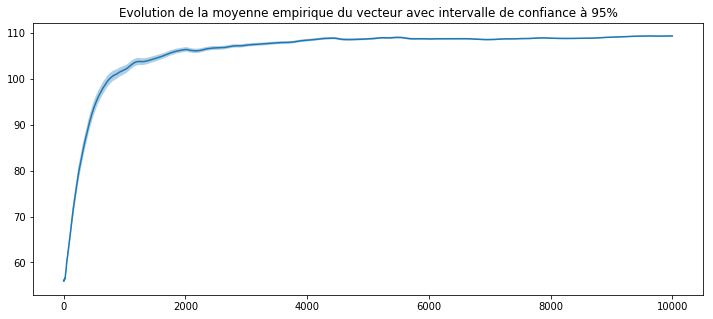

In [8]:
evolution(P[0])

In [9]:
from scipy.ndimage.interpolation import shift
from scipy.stats import chi2_contingency

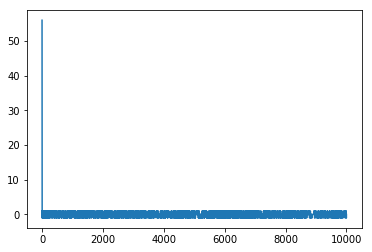

In [10]:
sP=shift(P[0], 1, cval=0)
plt.plot(P[0]-sP)

In [11]:
n=0

np.array([P[0][:5],P[0][5*n+1:5*(n+1)+1]])

array([[56, 56, 56, 56, 56],
       [56, 56, 56, 56, 57]])

In [12]:
chi2_contingency(np.array([P[0][:5],P[0][5*n+1:5*(n+1)+1]]))[1]

0.9999937717895058

In [13]:
def test_indep_evolution(V,effectif=5):
    
# effectif=5 (Cochran),  effectif=10 (Cramér) ou  effectif=20 (Kendall)

    l=[]
    for n in range(len(V)//effectif) :
        
        l+=[chi2_contingency(np.array([V[:effectif],V[effectif*n+1:effectif*(n+1)+1]]))[1]]
    
    plt.plot(l)

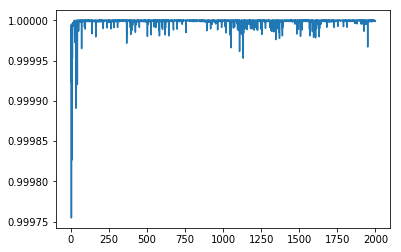

In [14]:
test_indep_evolution(P[0],effectif=5)

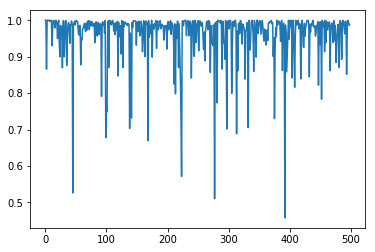

In [15]:
test_indep_evolution(P[1],effectif=20)

## Question 2

## Question 3